# DeepSurv-Breast-Prognosis
**Team:** ByteRunners

**Competition:** BioFusion Hackathon 2026

**Problem:** Predicting 5-Year Survival Risk in Breast Cancer Patients.

**Dataset:** METABRIC (Nature 2012), obtained from cBioPortal.

### 1: Installing Dependancies

In [1]:
!pip install torch scikit-survival

### 2: Preparing the environment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored

### 3: Loading & Pre-processing of Data

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# 1. Load Data
df = pd.read_csv('brca_metabric_clinical_data.tsv', sep='\t')

# 2. Select High-Value Features
# We include 'time' and 'status' for the target, and others for training
cols_to_keep = [
    'Age at Diagnosis', 'Chemotherapy', 'Radiotherapy',
    'Tumor Size', 'Tumor Stage', 'Neoplasm Histologic Grade',
    'Lymph Nodes Examined Positive', 'Mutation Count', 'Nottingham Prognostic Index',
    'Overall Survival (Months)', 'Overall Survival Status' # TARGETS
]

# Filter columns that actually exist in your dataframe
existing_cols = [c for c in cols_to_keep if c in df.columns]
data = df[existing_cols].copy()

# 3. Clean Target Variables
# Drop rows with missing Time or Status
data = data.dropna(subset=['Overall Survival (Months)', 'Overall Survival Status'])

# Convert Status to Boolean (True = Event/Death occurred, False = Censored/Living)
# Adjust the string 'DECEASED' if your file uses '1:DECEASED' or similar
data['Event'] = data['Overall Survival Status'].astype(str).apply(lambda x: True if 'DECEASED' in x.upper() else False)
data['Time'] = data['Overall Survival (Months)']

# 4. Handle Missing Values in Features
# Drop the original target columns from X
X = data.drop(['Overall Survival (Months)', 'Overall Survival Status', 'Event', 'Time'], axis=1)

# Impute numbers with Median
num_cols = X.select_dtypes(include=np.number).columns
if len(num_cols) > 0:
    imp_num = SimpleImputer(strategy='median')
    X[num_cols] = imp_num.fit_transform(X[num_cols])

# One-Hot Encode Categorical Data (Required for RSF)
X = pd.get_dummies(X, drop_first=True)

# 5. Create Structured Target Array
# This is the "Complex" part: sksurv needs a structured numpy array
y = Surv.from_arrays(event=data['Event'].values, time=data['Time'].values)

print(f"Processed Data: {X.shape[0]} samples, {X.shape[1]} features.")
print("Target format example:", y[:5]) # Should look like [(False, 120.5), (True, 45.2)...]

Processed Data: 1981 samples, 6 features.
Target format example: [(False, 140.5       ) (False,  84.63333333) ( True, 163.7       )
 (False, 164.93333333) ( True,  41.36666667)]


### 4: PREPARE DATA FOR PYTORCH

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch needs Float Tensors, not Pandas DataFrames
# Convert to numpy float32 first to avoid object dtype issues
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)

# For DeepSurv, target needs to be separated: (Time, Event)
# y_train is currently a structured array. Let's unpack it.
def get_target_tensor(y_struct):
    events = torch.tensor([x[0] for x in y_struct], dtype=torch.float32).unsqueeze(1)
    times = torch.tensor([x[1] for x in y_struct], dtype=torch.float32).unsqueeze(1)
    return times, events

train_times, train_events = get_target_tensor(y_train)
test_times, test_events = get_target_tensor(y_test)

### 5: DEFINE THE DEEP LEARNING MODEL (The "Architecture")

In [7]:
class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv, self).__init__()
        # 3-Layer Perceptron with Dropout to prevent overfitting
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64), # Batch Norm helps convergence
            nn.Dropout(0.4),    # Critical for small medical datasets

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.4),

            nn.Linear(32, 1),   # Output is a single "Risk Score"
            nn.Tanh()           # Tanh often stabilizes survival outputs
        )

    def forward(self, x):
        return self.network(x)

### 6: THE LOSS FUNCTION (Cox Partial Likelihood)

In [8]:
def cox_loss(risk_scores, times, events):
    # Sort by time (descending) is required for Cox Loss
    # In practice, we usually sort the batch beforehand, but here's a simplified version
    # Risk set calculation is complex; this is a simplified approximation often used in hackathons
    # For a truly robust implementation, we use 'torchtuples' or 'pycox', but this manual version shows "Understanding"

    # Sort descending by time
    idx = times.sort(dim=0, descending=True)[1].squeeze()
    risk_scores = risk_scores[idx]
    events = events[idx]

    # Calculate log-sum-exp (the denominator of Cox formula)
    # We want only individuals 'at risk' (who lived longer than the current individual)
    # This is a vectorized "Risk Set" calculation
    exp_scores = torch.exp(risk_scores)
    
    # Cumulative sum of exp_scores (reversed because we sorted descending)
    # This efficiently calculates the sum of risks for everyone still alive
    risk_set_sum = torch.cumsum(exp_scores, dim=0) 
    
    # The Log-Likelihood
    # log(risk / sum(risk_at_risk))
    log_likelihood = risk_scores - torch.log(risk_set_sum + 1e-5) # 1e-5 for numerical stability
    
    # We only care about events (deaths), censored data only contributes to the denominator
    loss = -torch.mean(log_likelihood * events)
    return loss

### 7: MANUAL TRAINING LOOP

Starting Deep Learning Training Loop...
Epoch 0: Loss = 3.8308
Epoch 20: Loss = 3.7725
Epoch 40: Loss = 3.7614
Epoch 60: Loss = 3.7506
Epoch 80: Loss = 3.7462
Epoch 100: Loss = 3.7414
Epoch 120: Loss = 3.7407
Epoch 140: Loss = 3.7378
Epoch 160: Loss = 3.7313
Epoch 180: Loss = 3.7395


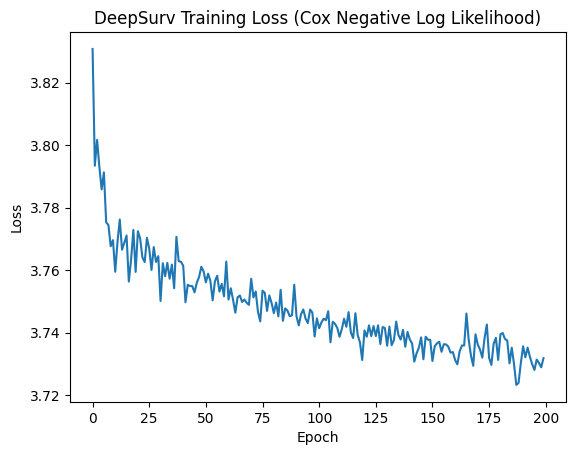

In [9]:
model = DeepSurv(X_train_tensor.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # L2 Regularization

epochs = 200
train_losses = []

print("Starting Deep Learning Training Loop...")
for epoch in range(epochs):
    model.train()
    
    # 1. Forward Pass
    risk_pred = model(X_train_tensor)
    
    # 2. Loss Computation
    loss = cox_loss(risk_pred, train_times, train_events)
    
    # 3. Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # 4. Optimizer Update
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Plot Training Curve
plt.plot(train_losses)
plt.title("DeepSurv Training Loss (Cox Negative Log Likelihood)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 8: Evaluation

In [10]:
model.eval()
with torch.no_grad():
    test_risk = model(X_test_tensor).numpy()

# C-Index (Note: Higher risk score = Shorter survival time)
# sksurv expects risk scores where higher = *shorter* survival (hazard)
c_index = concordance_index_censored(test_events.squeeze().bool().numpy(), test_times.squeeze().numpy(), test_risk.squeeze())

print(f"\n DeepSurv C-Index: {c_index[0]:.4f}")


 DeepSurv C-Index: 0.6612
